# Einstieg Python

## 1. Import der benötigten Module:

In [1]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import folium
import warnings

Warnungen können erst einmal unterdrückt werden

In [2]:
warnings.filterwarnings('ignore')

## 2. Daten einladen und explorieren 

Laden Sie die *Berliner Bezirksdaten (Polygone)* und die *Berliner Bars (Punkte von OpenStreetMap extrahiert, s. Seminarblock 4)* ein.

In [3]:
districts = gp.read_file("./data/bezirke_EPSG32633.shp")
bars = gp.read_file("./data/bars_bln.gpkg")

Lassen Sie sich die Attributtabelle des *Bezirke-Layers* über den *print*-Befehl anzeigen:

In [4]:
print('Das ist der Bezirke GeoDataFrame.')
print(districts)

Das ist der Bezirke GeoDataFrame.
    Bezirk_ID                  BEZIRK_NAM  \
0           1                       Mitte   
1           2               Reinickendorf   
2           3         Steglitz-Zehlendorf   
3           4        Tempelhof-Schöneberg   
4           5             Treptow-Köpenik   
5           6    Friedrichshain-Kreuzberg   
6           7                     Neuölln   
7           8                      Pankow   
8           9                 Lichtenberg   
9          10         Marzahn-Hellersdorf   
10         11  Charlottenburg-Wilmersdorf   
11         12                     Spandau   

                                             geometry  
0   POLYGON ((390771.100 5825398.601, 390774.900 5...  
1   POLYGON ((389457.600 5831851.601, 389468.100 5...  
2   POLYGON ((385877.400 5814307.201, 385914.100 5...  
3   POLYGON ((389320.700 5817777.801, 389334.900 5...  
4   POLYGON ((397523.500 5816325.801, 397535.500 5...  
5   POLYGON ((396334.700 5820049.301, 396343

Schauen Sie sich die *geometry-Spalte* genauer an. Welche Informationen werden hier gespeichert?



<details>

<summary> <b>Antwort - klicken zum ausklappen</b></summary>
    
Die <i>*geometry-Spalte*</i> beinhaltet sowohl Informationen zu den Geometrien (Punkte, Linien oder Polygone) der einzelnen Elemente, als auch Informationen zum gespeichterten Koordinatensystem.

</details>


Nutzen Sie den *print-Befehl*, um sich die Attributtabelle vom *Bars-Layer* anzeigen zu lassen.

Können Sie aus dem Output herausfinden, wie viele Zeilen und Spalten der *Bars-Layer* hat?

In [5]:
print('Das ist der Bar GeoDataFrame.')
print(bars)

Das ist der Bar GeoDataFrame.
         full_id      osm_id osm_type amenity survey:date drink:coffee  \
0      n79675952    79675952     node     bar        None         None   
1      n86001835    86001835     node     bar        None         None   
2      n86005430    86005430     node     bar        None         None   
3     n111644760   111644760     node     bar        None         None   
4     n149607257   149607257     node     bar        None         None   
..           ...         ...      ...     ...         ...          ...   
796  n9531153633  9531153633     node     bar        None         None   
797  n9531153639  9531153639     node     bar        None         None   
798  n9556212662  9556212662     node     bar        None         None   
799  n9562206135  9562206135     node     bar  2022-03-02         None   
800  n9577764498  9577764498     node     bar        None         None   

    name:ar indoor_seating microbrewery name:en  ...  smoking  \
0      None     

Um einen besseren Überblick zu bekommen, welche Spalten in einem Datensatz enthalten sind (ähnlich zu den Spalten von *Attributtabellen* in *QGIS*), *printen* Sie sich lediglich die Spalten (columns). Erläuterungen zu den einzelnen Spalten bekommen sie [hier](https://wiki.openstreetmap.org/wiki/Map_features#Additional_properties). 

In [6]:
print('Das sind alle Spalten des Bar-GeoDataFrames.')
print(bars.columns.tolist())

Das sind alle Spalten des Bar-GeoDataFrames.
['full_id', 'osm_id', 'osm_type', 'amenity', 'survey:date', 'drink:coffee', 'name:ar', 'indoor_seating', 'microbrewery', 'name:en', 'name:de', 'note:de', 'toilets:access', 'toilets', 'male', 'fetish:uniform', 'fetish:sneakers', 'fetish:skins', 'fetish:jeans', 'gay:women', 'organic', 'opening', 'diet:vegan', 'addr:city:fa', 'name:uk', 'tourism', 'contact:phone:description', 'opening_hours:kitchen', 'name:signed', 'leisure', 'takeaway', 'internet_access:operator', 'wheelchair:note', 'billiards:snooker', 'billiards:pool', 'wheelchair:description:en', 'wheelchair:description:de', 'mode_of_organisation:self_managed', 'identity', 'smoking_hours', 'smoking:outside', 'smokefree', 'nohousenumber', 'fetish:rubber', 'fetish:leather', 'darkroom', 'payment:visa_electron', 'payment:visa_debit', 'payment:visa', 'payment:mastercard', 'payment:maestro', 'payment:jcb', 'payment:ep_geldkarte', 'payment:electronic_purses', 'payment:discover_card', 'payment:dine

Wir konzentrieren uns für die nächsten Schritte nur auf die Spalten 'full_id', 'name' und 'geometry'. Wir selektieren diese Spalten und speichern diese in einer neuen Variable .

In [7]:
bars_selected = bars[['full_id', 'name', 'geometry']]
print(bars_selected)

         full_id                name                   geometry
0      n79675952            Albert's  POINT (13.32885 52.56382)
1      n86001835      Bellboy Berlin  POINT (13.39194 52.51203)
2      n86005430          Newton Bar  POINT (13.39123 52.51293)
3     n111644760  No Limit Shishabar  POINT (13.32093 52.56556)
4     n149607257          en passant  POINT (13.41298 52.54420)
..           ...                 ...                        ...
796  n9531153633           Miami Bar  POINT (13.51607 52.45452)
797  n9531153639           Arkadasch  POINT (13.51554 52.45484)
798  n9556212662         CocktailBar  POINT (13.49518 52.53472)
799  n9562206135          Operlounge  POINT (13.30804 52.51141)
800  n9577764498              Melodi  POINT (13.36887 52.54409)

[801 rows x 3 columns]


## 3. Koordinatenbezugssysteme

In einem nächsten Schritt wollen wir die die Koordinatensysteme der Datensätze bestimmen und ggf. reprojizieren.

In [8]:
print('Das ist das CRS vom Bezirke-Layer:')
print(districts.crs)

Das ist das CRS vom Bezirke-Layer:
epsg:32633


In [9]:
print('Das ist das CRS vom Bar-Layer:')
print(bars_selected.crs)

Das ist das CRS vom Bar-Layer:
epsg:4326


Liegen die beiden Datensätze im selben Koordinatenystem vor? Suchen sie weitere Informationen zu den Koordinatensystem, z.B. unter https://epsg.io/. 

<details>

<summary> <b>Antwort - klicken zum ausklappen</b></summary>
    
Die beiden Datensätze haben unterschiedliche Koordinatensysteme: 
    
Der Bezrike-Layer liegt im Koordinatensystem <a href="https://epsg.io/32633">WGS 84 / UTM zone 33N</a> vor. 
    
Der Bar-Layer liegt im Koordinatensystem <a href="https://epsg.io/4326">World Geodetic System 1984</a> vor.


</details>

Reprojizieren Sie das Koordinatenystem des *Bar-Layers* in das Koordinatenystem vom *Bezirke-Layer* mit der Funktion *to_crs()* und speichern das Ergebnis als neue Variable.

In [10]:
bars_selected_reproj = bars_selected.to_crs(districts.crs)
print(bars_selected_reproj.crs)

epsg:32633


## 4. statische Visualisierung

Sie können sich die Datensätze für einen schnellen Überblick visualisieren lassen. 

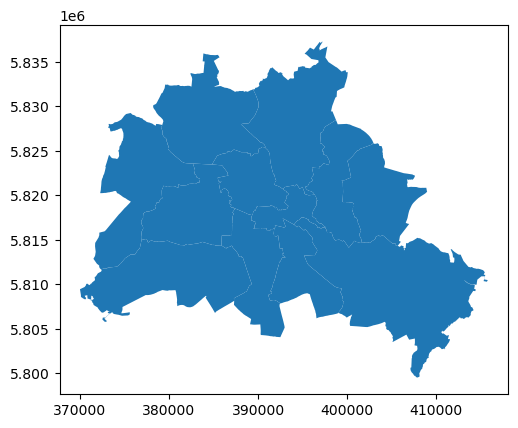

In [11]:
# Bezirke-Layer
districts.plot()
plt.show()

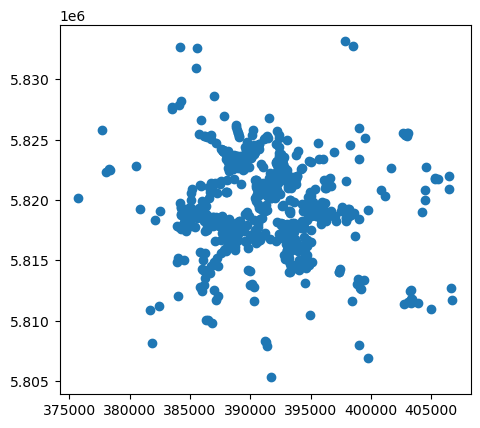

In [12]:
# Bar-Layer
bars_selected_reproj.plot()
plt.show()

Sie können auch mehrere Datensätze in einer Karte abbilden. Auch lassen sich Farben, Größen, Umrisse etc. verändern. Probieren Sie gerne weitere Darstellungsoptionen aus.

<AxesSubplot:>

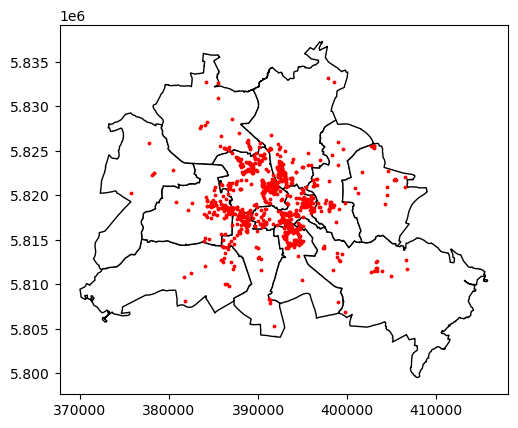

In [13]:
base = districts.plot(color='white', edgecolor='black')

bars_selected_reproj.plot(ax=base, marker='o', color='red', markersize=3)

## 4. Spatial Join

Nun wollen wir herausfinden, **wie viele Bars es pro Bezirk gibt**. 

Dazu führen Sie in einem ersten Schritt einen *Spatial Join* durch. *Spatial Joins* dienen dazu, zwei Datensätze räumlich zu verknüpfen. Attribute werden aus dem ersten Datensatz an die Attribute im zweiten Datensatz auf Grundlage der relativen räumlichen Beziehung zwischen den Geometrien der beiden Datensätze angefügt. Eine Erklärung der verschiedenen Arten von relativen räumlichen Beziehung finden Sie [hier](https://pygis.io/docs/e_spatial_joins.html). Schauen Sie sich an, was die unterschiedlichen relativen räumlichen Beziehung (=Predicates) bedeuten (intersects, contains, equals, touches, overlaps, within, crosses).

In *QGIS* vollzieht man den folgenden *Spatial Join* über das Tool *Join Attributes by Location* aus der *Processing Toolbox*.


In [14]:
districts

,Bezirk_ID,BEZIRK_NAM,geometry
0,1,Mitte,"POLYGON ((390771.100 5825398.601, 390774.900 5..."
1,2,Reinickendorf,"POLYGON ((389457.600 5831851.601, 389468.100 5..."
2,3,Steglitz-Zehlendorf,"POLYGON ((385877.400 5814307.201, 385914.100 5..."
3,4,Tempelhof-Schöneberg,"POLYGON ((389320.700 5817777.801, 389334.900 5..."
4,5,Treptow-Köpenik,"POLYGON ((397523.500 5816325.801, 397535.500 5..."
5,6,Friedrichshain-Kreuzberg,"POLYGON ((396334.700 5820049.301, 396343.200 5..."
6,7,Neuölln,"POLYGON ((394057.400 5816675.701, 394085.800 5..."
7,8,Pankow,"POLYGON ((398750.900 5828436.601, 398738.000 5..."
8,9,Lichtenberg,"POLYGON ((402938.800 5825899.301, 402907.000 5..."
9,10,Marzahn-Hellersdorf,"POLYGON ((405685.600 5814291.501, 405680.700 5..."


In [15]:
bars_and_districts = districts.sjoin(bars_selected_reproj, predicate = 'contains')
print(bars_and_districts)

    Bezirk_ID BEZIRK_NAM                                           geometry  \
0           1      Mitte  POLYGON ((390771.100 5825398.601, 390774.900 5...   
0           1      Mitte  POLYGON ((390771.100 5825398.601, 390774.900 5...   
0           1      Mitte  POLYGON ((390771.100 5825398.601, 390774.900 5...   
0           1      Mitte  POLYGON ((390771.100 5825398.601, 390774.900 5...   
0           1      Mitte  POLYGON ((390771.100 5825398.601, 390774.900 5...   
..        ...        ...                                                ...   
11         12    Spandau  POLYGON ((379237.000 5827876.801, 379170.900 5...   
11         12    Spandau  POLYGON ((379237.000 5827876.801, 379170.900 5...   
11         12    Spandau  POLYGON ((379237.000 5827876.801, 379170.900 5...   
11         12    Spandau  POLYGON ((379237.000 5827876.801, 379170.900 5...   
11         12    Spandau  POLYGON ((379237.000 5827876.801, 379170.900 5...   

    index_right      full_id                       

Schauen Sie sich das Ergebnis genau an. Was ist passiert?

Nun wollen wir in einem nächsten Schritt berechnen, wie viele Bars es pro Bezirk gibt. Dazu nutzen wir die Funktionen *groupby()* und *size()*.

In [16]:
count_bars_per_district = bars_and_districts.groupby('BEZIRK_NAM').size().rename('count_per_district')
print(count_bars_per_district)

BEZIRK_NAM
Charlottenburg-Wilmersdorf     74
Friedrichshain-Kreuzberg      140
Lichtenberg                    35
Marzahn-Hellersdorf            18
Mitte                         194
Neuölln                        94
Pankow                         96
Reinickendorf                  26
Spandau                         6
Steglitz-Zehlendorf            18
Tempelhof-Schöneberg           74
Treptow-Köpenik                26
Name: count_per_district, dtype: int64


Nun wollen wir das Ergebnis wieder mit unserem ursprünglichen *Bezirke-Layer* zusammenführen. Dafür nutzen wir die Funktion *merge* aus dem Modul *Pandas*.

In [17]:
districts_with_bars = pd.merge(districts, count_bars_per_district, how='inner', on=['BEZIRK_NAM'])

Wir können uns die Ergebnisse auch in einem Barplot anzeigen lassen: 

<BarContainer object of 12 artists>

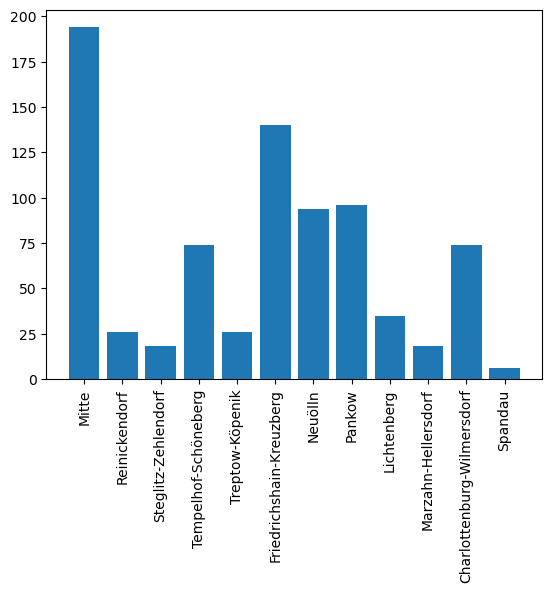

In [18]:
plt.xticks(rotation='vertical')
plt.bar(districts_with_bars.BEZIRK_NAM, districts_with_bars.count_per_district)

## 5. interaktive Visualisierung

Zum Schluss wollen wir uns noch das Modul *Folium* anschauen. *Folium* ermöglicht uns mit wenige Zeilen Code eine **interaktive Web-Karte** zu erstellen. Dabei greift *Folium* auf die Open-Source JavaScript Bücherei [*Leaflet*](https://leafletjs.com/) drauf zu.

Zuerst müssen wir eine neue *ID-Spalte* einfügen.

In [19]:
districts_with_bars["id"] = districts_with_bars.index.astype(str)

Jetzt können wir die interaktive Karte darstellen.

In [20]:
# create base interactive map
interactive_map = folium.Map(
    location=(52.51791,13.39339),
    zoom_start=10
)

# define input layer
districts_with_bars_layer = folium.Choropleth(
    geo_data=districts_with_bars,
    data=districts_with_bars,
    columns=("id", "count_per_district"),
    key_on="feature.id",
    legend_name="Bars per district, Berlin",
)

# add input layer to base layer
districts_with_bars_layer.add_to(interactive_map)


# add tooltipp to display values 
def style_function(feature):
    return {
        "color": "transparent",
        "fillColor": "transparent"
    }

# More complex tooltips can be created using the
# `folium.features.GeoJsonTooltip` class. Below, we use
# its most basic features: `fields` specifies which columns
# should be displayed, `aliases` how they should be labelled.
tooltip = folium.features.GeoJsonTooltip(
    fields=(["BEZIRK_NAM", "count_per_district"]),
    aliases=(["District:", "Bars per district:"])
)

# create tooltipp layer
tooltip_layer = folium.features.GeoJson(
    districts_with_bars,
    style_function=style_function,
    tooltip=tooltip
)

# add tooltipp layer to base layer
tooltip_layer.add_to(interactive_map)

# display map
interactive_map